In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
from imgaug import augmenters as iaa
sns.set(style="darkgrid", font_scale=1.0)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import io 
import pandas as pd

from tensorflow import keras
from keras.models import load_model
from keras.utils import plot_model
from keras import regularizers
from keras.callbacks import LearningRateScheduler

from keras import backend as K

In [ ]:
# print version number
print(tf.__version__)

2.3.0


In [ ]:
# check GPU specs
!nvidia-smi

Wed Oct 28 11:52:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# dataset normalization

def normalization(mode, x):
  # normalize using mean and standard deviation
  mean, std = x.mean(), x.std()  
  x = (x - mean) / std  

  return x

In [ ]:
img_width, img_height = 32, 32

# handle image format
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

# download cifar data and split into train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# normalizing and scaling by pixels
x_train = normalization('mean', x_train)
x_test = normalization('mean', x_test)
x_train = x_train / 255.0
x_test = x_test / 255.0

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


In [ ]:
# image augmentation
seq = iaa.Sequential([
  iaa.Fliplr(0.5),
  iaa.Sometimes(
      0.5,
      iaa.GaussianBlur(sigma=(0, 0.5))
  )
], random_order=True)

# append augmented images to dataset to increase dataset size
aug_img = seq.augment_images(x_train)
x_train = np.append(x_train, aug_img, axis=0)
y_train = np.append(y_train, y_train, axis=0)

print("Dataset size:", x_train.shape, "Label size:", y_train.shape)

Dataset size: (100000, 32, 32, 3) Label size: (100000, 1)


In [ ]:
class LearningRate(tf.keras.callbacks.Callback):
  
  def on_train_begin(self,logs={}):
    self.lr_epoch=[]

  def on_epoch_end(self, batch, logs={}):
    self.lr_epoch.append(step_decay(len(self.lr_epoch)+1, weight_decay))
		
def step_decay(epoch, initial_lrate):
	drop = 0.05
	epochs_drop = 30
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [ ]:
def model_(model_type):
  if model_type is 'A':
    # Network for Part A
    model = keras.Sequential([    
      # Stage 1                    
      keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # Stage 2
      keras.layers.ZeroPadding2D(padding=(1, 1)),
      keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # Stage 3
      keras.layers.ZeroPadding2D(padding=(1, 1)),
      keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # FC - Output
      keras.layers.Flatten(),
      keras.layers.Dense(500),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

  if model_type is 'B':
    # Network for Part B
    model = keras.Sequential([    
      # Stage 1                        
      keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # Stage 2
      keras.layers.ZeroPadding2D(padding=(1, 1)),
      keras.layers.Conv2D(filters=32, kernel_size=1, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.Conv2D(filters=64, kernel_size=1, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # Stage 3
      keras.layers.ZeroPadding2D(padding=(1, 1)),
      keras.layers.Conv2D(filters=64, kernel_size=1, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.Conv2D(filters=128, kernel_size=1, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      keras.layers.GlobalAveragePooling2D(),
      # FC - Output
      keras.layers.Flatten(),
      keras.layers.Dense(500),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

  if model_type is 'C':
    # Network for Part C
    model = keras.Sequential([    
      # Stage 1
      keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # Stage 2
      keras.layers.ZeroPadding2D(padding=(1, 1)),
      keras.layers.SeparableConv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # Stage 3
      keras.layers.ZeroPadding2D(padding=(1, 1)),
      keras.layers.SeparableConv2D(filters=128, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=(2,2), padding='same', strides=2),  
      keras.layers.BatchNormalization(),
      # FC - Output
      keras.layers.Flatten(),
      keras.layers.Dense(500),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

  return model

In [ ]:
epochs = 50
batch_size = 64
weight_decay = 0.001
model = model_('B')

lr_history=LearningRate()
lrate = LearningRateScheduler(step_decay, weight_decay)
callbacks_list = [lr_history,lrate]
model.compile(optimizer=tf.keras.optimizers.SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
model.summary()
train_model = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=batch_size, callbacks=callbacks_list, shuffle=True)
time_taken = time.time() - start_time
print('Time taken for %d epochs: %.4f' % (epochs, time_taken))

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy: {:5.2f}%'.format(100 * test_acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 32)        1056      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        2

In [ ]:
# logging and history

# get model summary string to be saved as text file
def get_model_summary(model):
  stream = io.StringIO()
  model.summary(print_fn=lambda x: stream.write(x + '\n'))
  summary_string = stream.getvalue()
  stream.close()
  return summary_string

model_summary_string = get_model_summary(model)
hist_df = pd.DataFrame(train_model.history)

# write history to log text file
file = open(r'drive/My Drive/log.txt', 'w')
file.write("Model summary: \n" + str(model_summary_string))
file.write("Number of Epochs: %d, Batch Size: %d" %(epochs, batch_size))
file.write("\n History: \n" + str(hist_df))
file.write(str("\nTime taken: %.4f," %((time_taken)) + ' Test accuracy: {:5.2f}%'.format(100 * test_acc)))
file.close()

In [ ]:
# Save entire model to a HDF5 file
model.save('drive/My Drive/model.h5')
print('Model saved.')

Model saved.


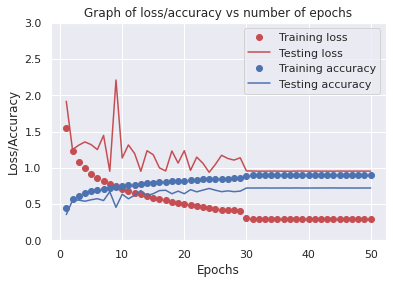

In [ ]:
# plot accuracy and loss of model in a graph
history = train_model.history
history.keys()

acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs_no = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs_no, loss, 'ro', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs_no, val_loss, 'r', label='Testing loss')
# "bo" is for "blue dot"
plt.plot(epochs_no, acc, 'bo', label='Training accuracy')
# b is for "solid blue line"
plt.plot(epochs_no, val_acc, 'b', label='Testing accuracy')
plt.title('Graph of loss/accuracy vs number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.ylim(0.0, 3.0)

# save graph and show
plt.savefig('drive/My Drive/model.png')
plt.show()